nodes:  50 links  69


/home/huang/anaconda3/envs/gt/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/huang/anaconda3/envs/gt/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min 
0  	300   	8902
1  	183   	8902
2  	185   	8902
3  	200   	8902
4  	168   	8902
5  	165   	8872
6  	194   	8802
7  	180   	8802
8  	180   	8802
9  	178   	8800
10 	172   	8800
11 	170   	8728
12 	174   	8728
13 	172   	8680
14 	178   	8680
15 	185   	8668
16 	182   	8648
17 	177   	8648
18 	169   	8584
19 	180   	8562
20 	173   	8494
21 	159   	8542
22 	186   	8470
23 	181   	8470
24 	162   	8470
25 	183   	8412
26 	176   	8412
27 	175   	8442
28 	165   	8402
29 	167   	8362
30 	160   	8362
31 	178   	8262
32 	175   	8262
33 	183   	8262
34 	190   	8262
35 	189   	8222
36 	172   	8138
37 	175   	8138
38 	179   	8138
39 	182   	8120
40 	188   	8120
41 	174   	8086
42 	187   	8086
43 	187   	8086
44 	177   	8010
45 	180   	8018
46 	193   	7990
47 	191   	7990
48 	176   	7990
49 	180   	7968
50 	179   	7934
51 	189   	7916
52 	171   	7924
53 	179   	7934
54 	182   	7904
55 	178   	7864
56 	187   	7838
57 	181   	7838
58 	185   	7784
59 	173   	7784
60 	165   	7768
61 	180 

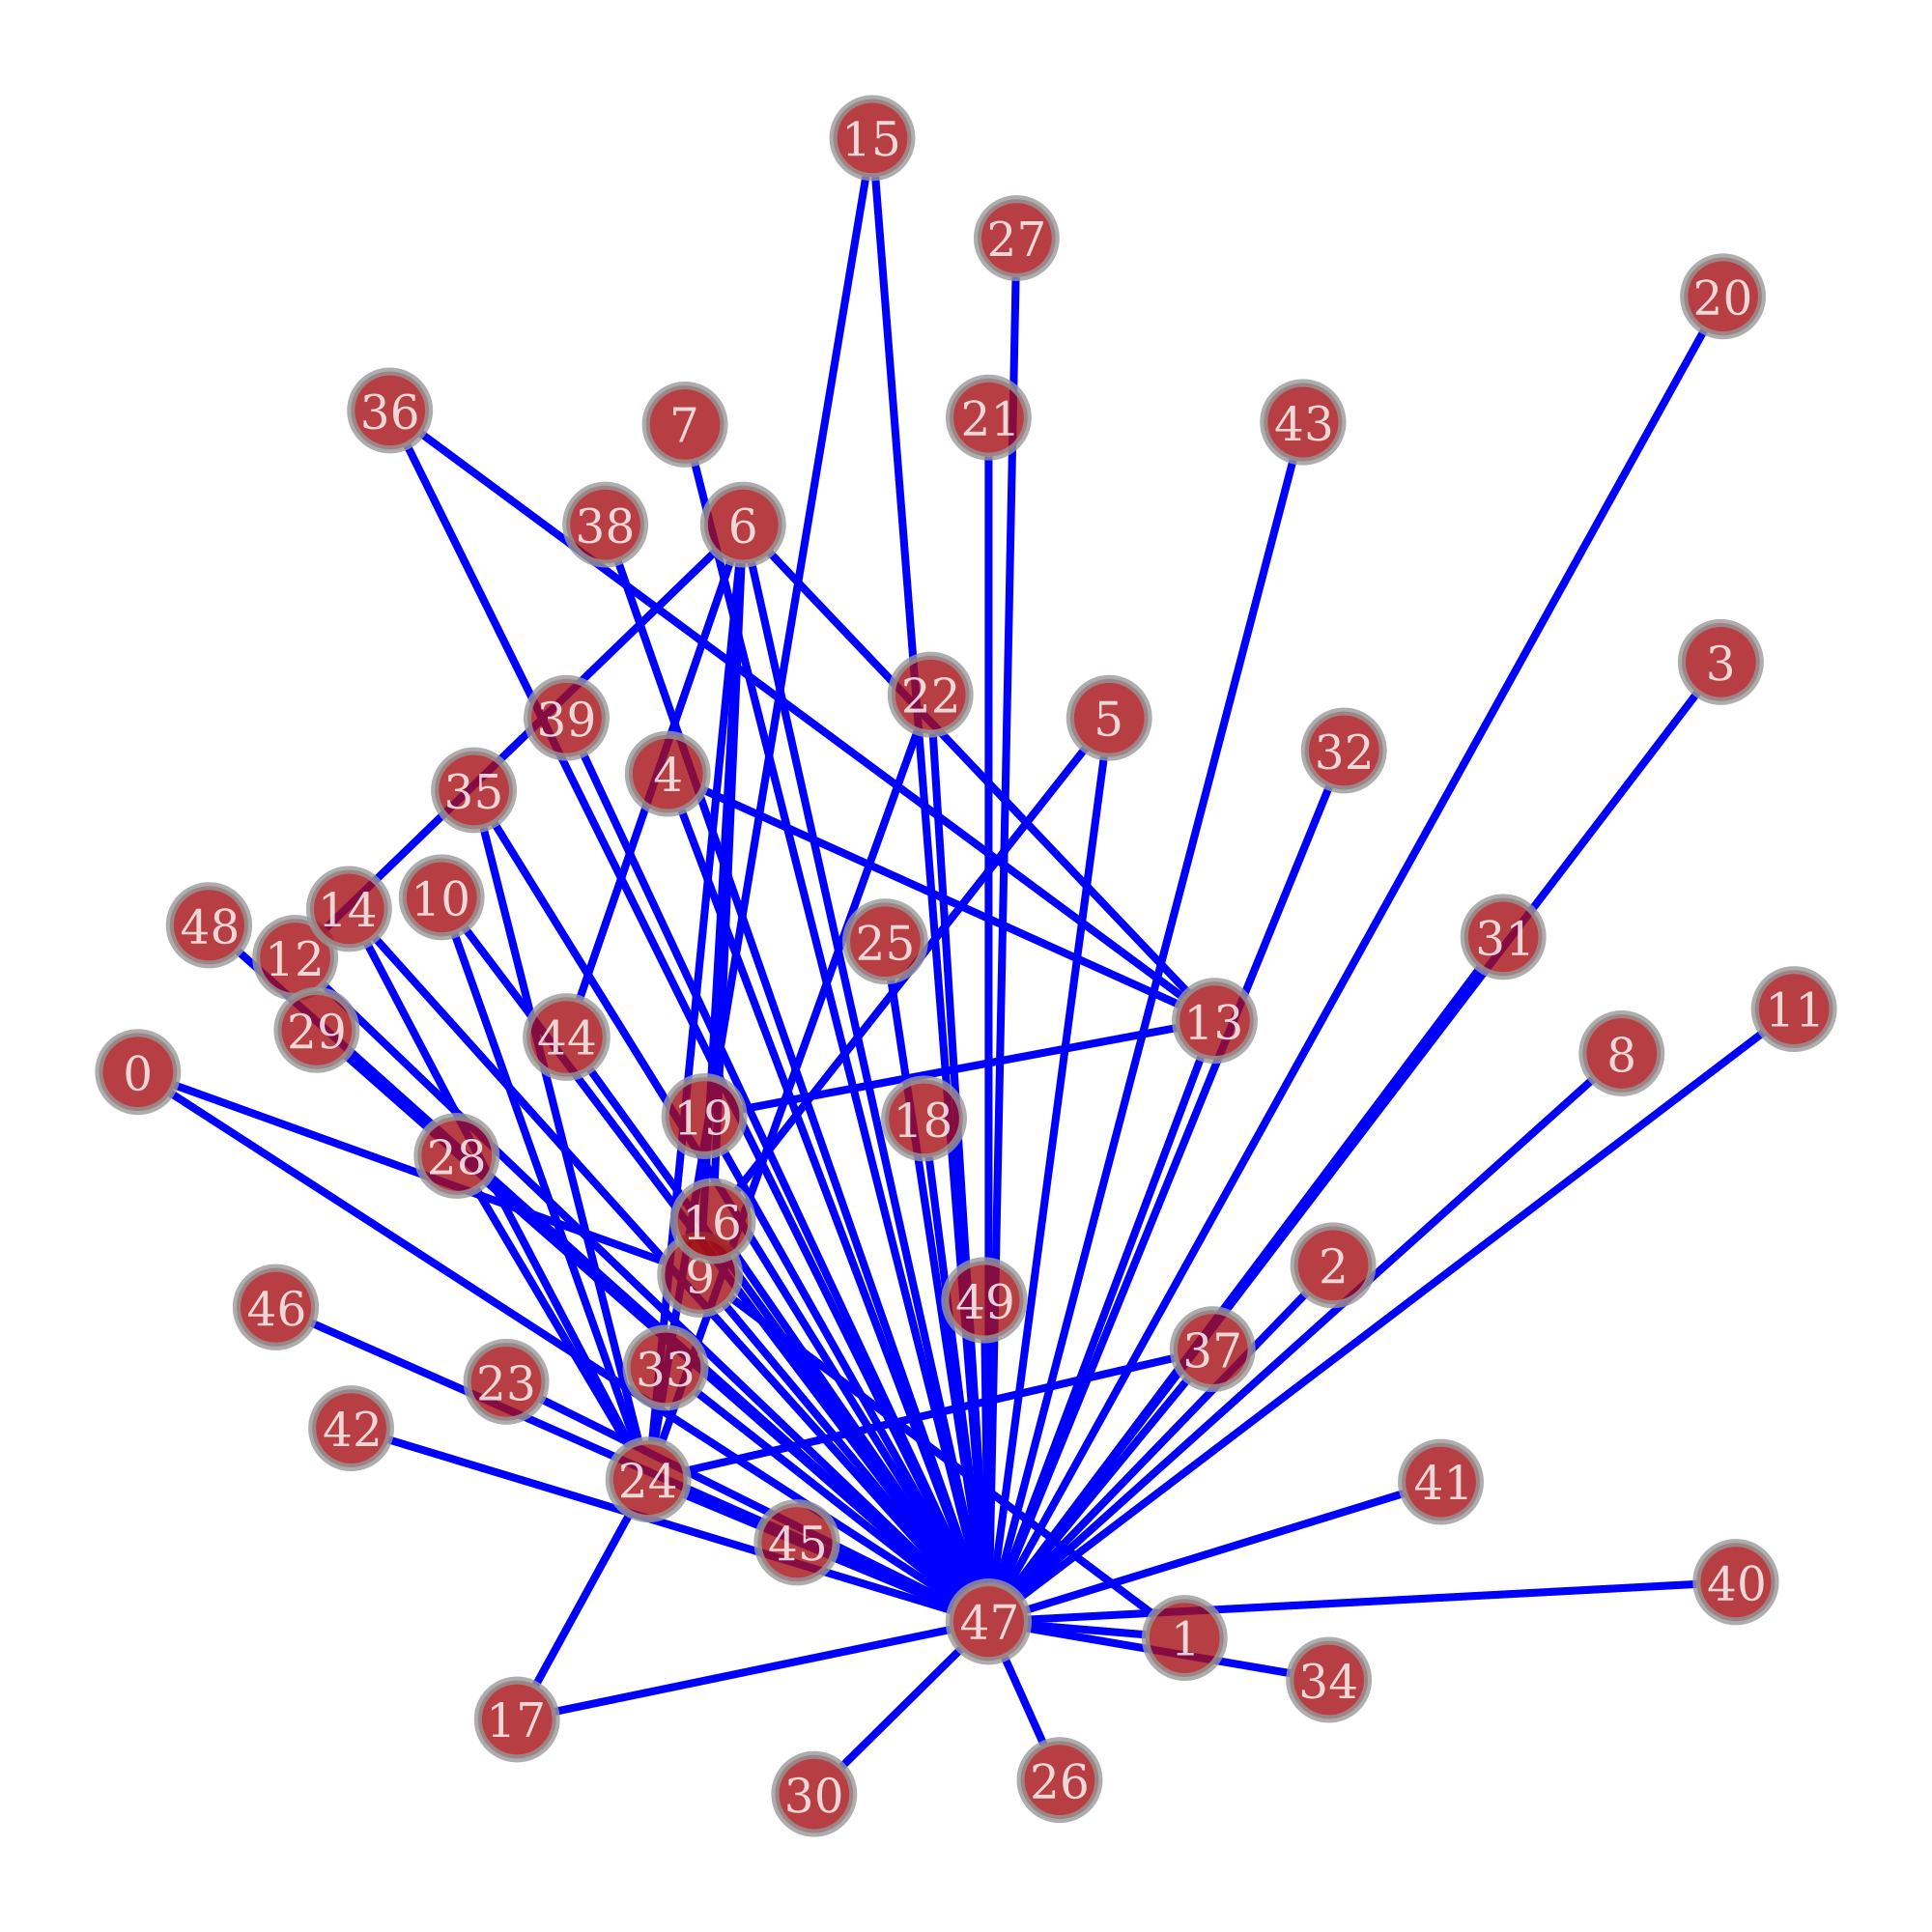

In [2]:
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import numpy as np
import random

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图　個体をグラフにデコードする
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                graph.add_edge(graph.vertex(i), graph.vertex(j))
    return graph

# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != 69:  # 边数限制，确保边数为69
        return float('inf'),  # 如果边数不为69，适应度设为无穷大
    dist_matrix = shortest_distance(graph).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,

# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))
    return new_ind1, new_ind2

# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))  # 图的维度
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]
    
    if edges and non_edges:
        # 移除一条边　1エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0
        
        # 添加一条边　1エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数为69　初期個体を初期化する際にエッジ数を69に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], 69)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)

# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=500, stats=stats, halloffame=hof, verbose=True)
    return pop, stats, hof

if __name__ == "__main__":
    pop, stats, hof = main()
    best_individual = hof[0]
    best_graph = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))


In [32]:
print("nodes: ", best_graph.num_vertices(), "links ", best_graph.num_edges())

nodes:  50 links  69


nodes:  50 links  69
gen	nevals	min 
0  	300   	8838
1  	162   	8838
2  	202   	9186
3  	174   	9108
4  	182   	9144
5  	193   	9144
6  	193   	9138
7  	173   	9114
8  	160   	9050
9  	164   	9050
10 	184   	8976
11 	181   	8976
12 	171   	8974
13 	174   	8964
14 	180   	8816
15 	196   	8816
16 	161   	8816
17 	194   	8706
18 	172   	8706
19 	158   	8706
20 	166   	8706
21 	192   	8660
22 	161   	8572
23 	167   	8572
24 	171   	8552
25 	183   	8552
26 	171   	8538
27 	177   	8416
28 	197   	8416
29 	176   	8416
30 	184   	8376
31 	164   	8376
32 	177   	8304
33 	164   	8304
34 	187   	8276
35 	180   	8246
36 	182   	8240
37 	181   	8246
38 	192   	8234
39 	189   	8218
40 	178   	8200
41 	168   	8188
42 	163   	8166
43 	184   	8166
44 	170   	8126
45 	187   	8126
46 	194   	8110
47 	187   	8038
48 	181   	8038
49 	186   	8038
50 	196   	8022
51 	180   	8016
52 	180   	8016
53 	183   	7970
54 	197   	7942
55 	178   	7942
56 	192   	7872
57 	175   	7872
58 	181   	7872
59 	155   	7872
60 

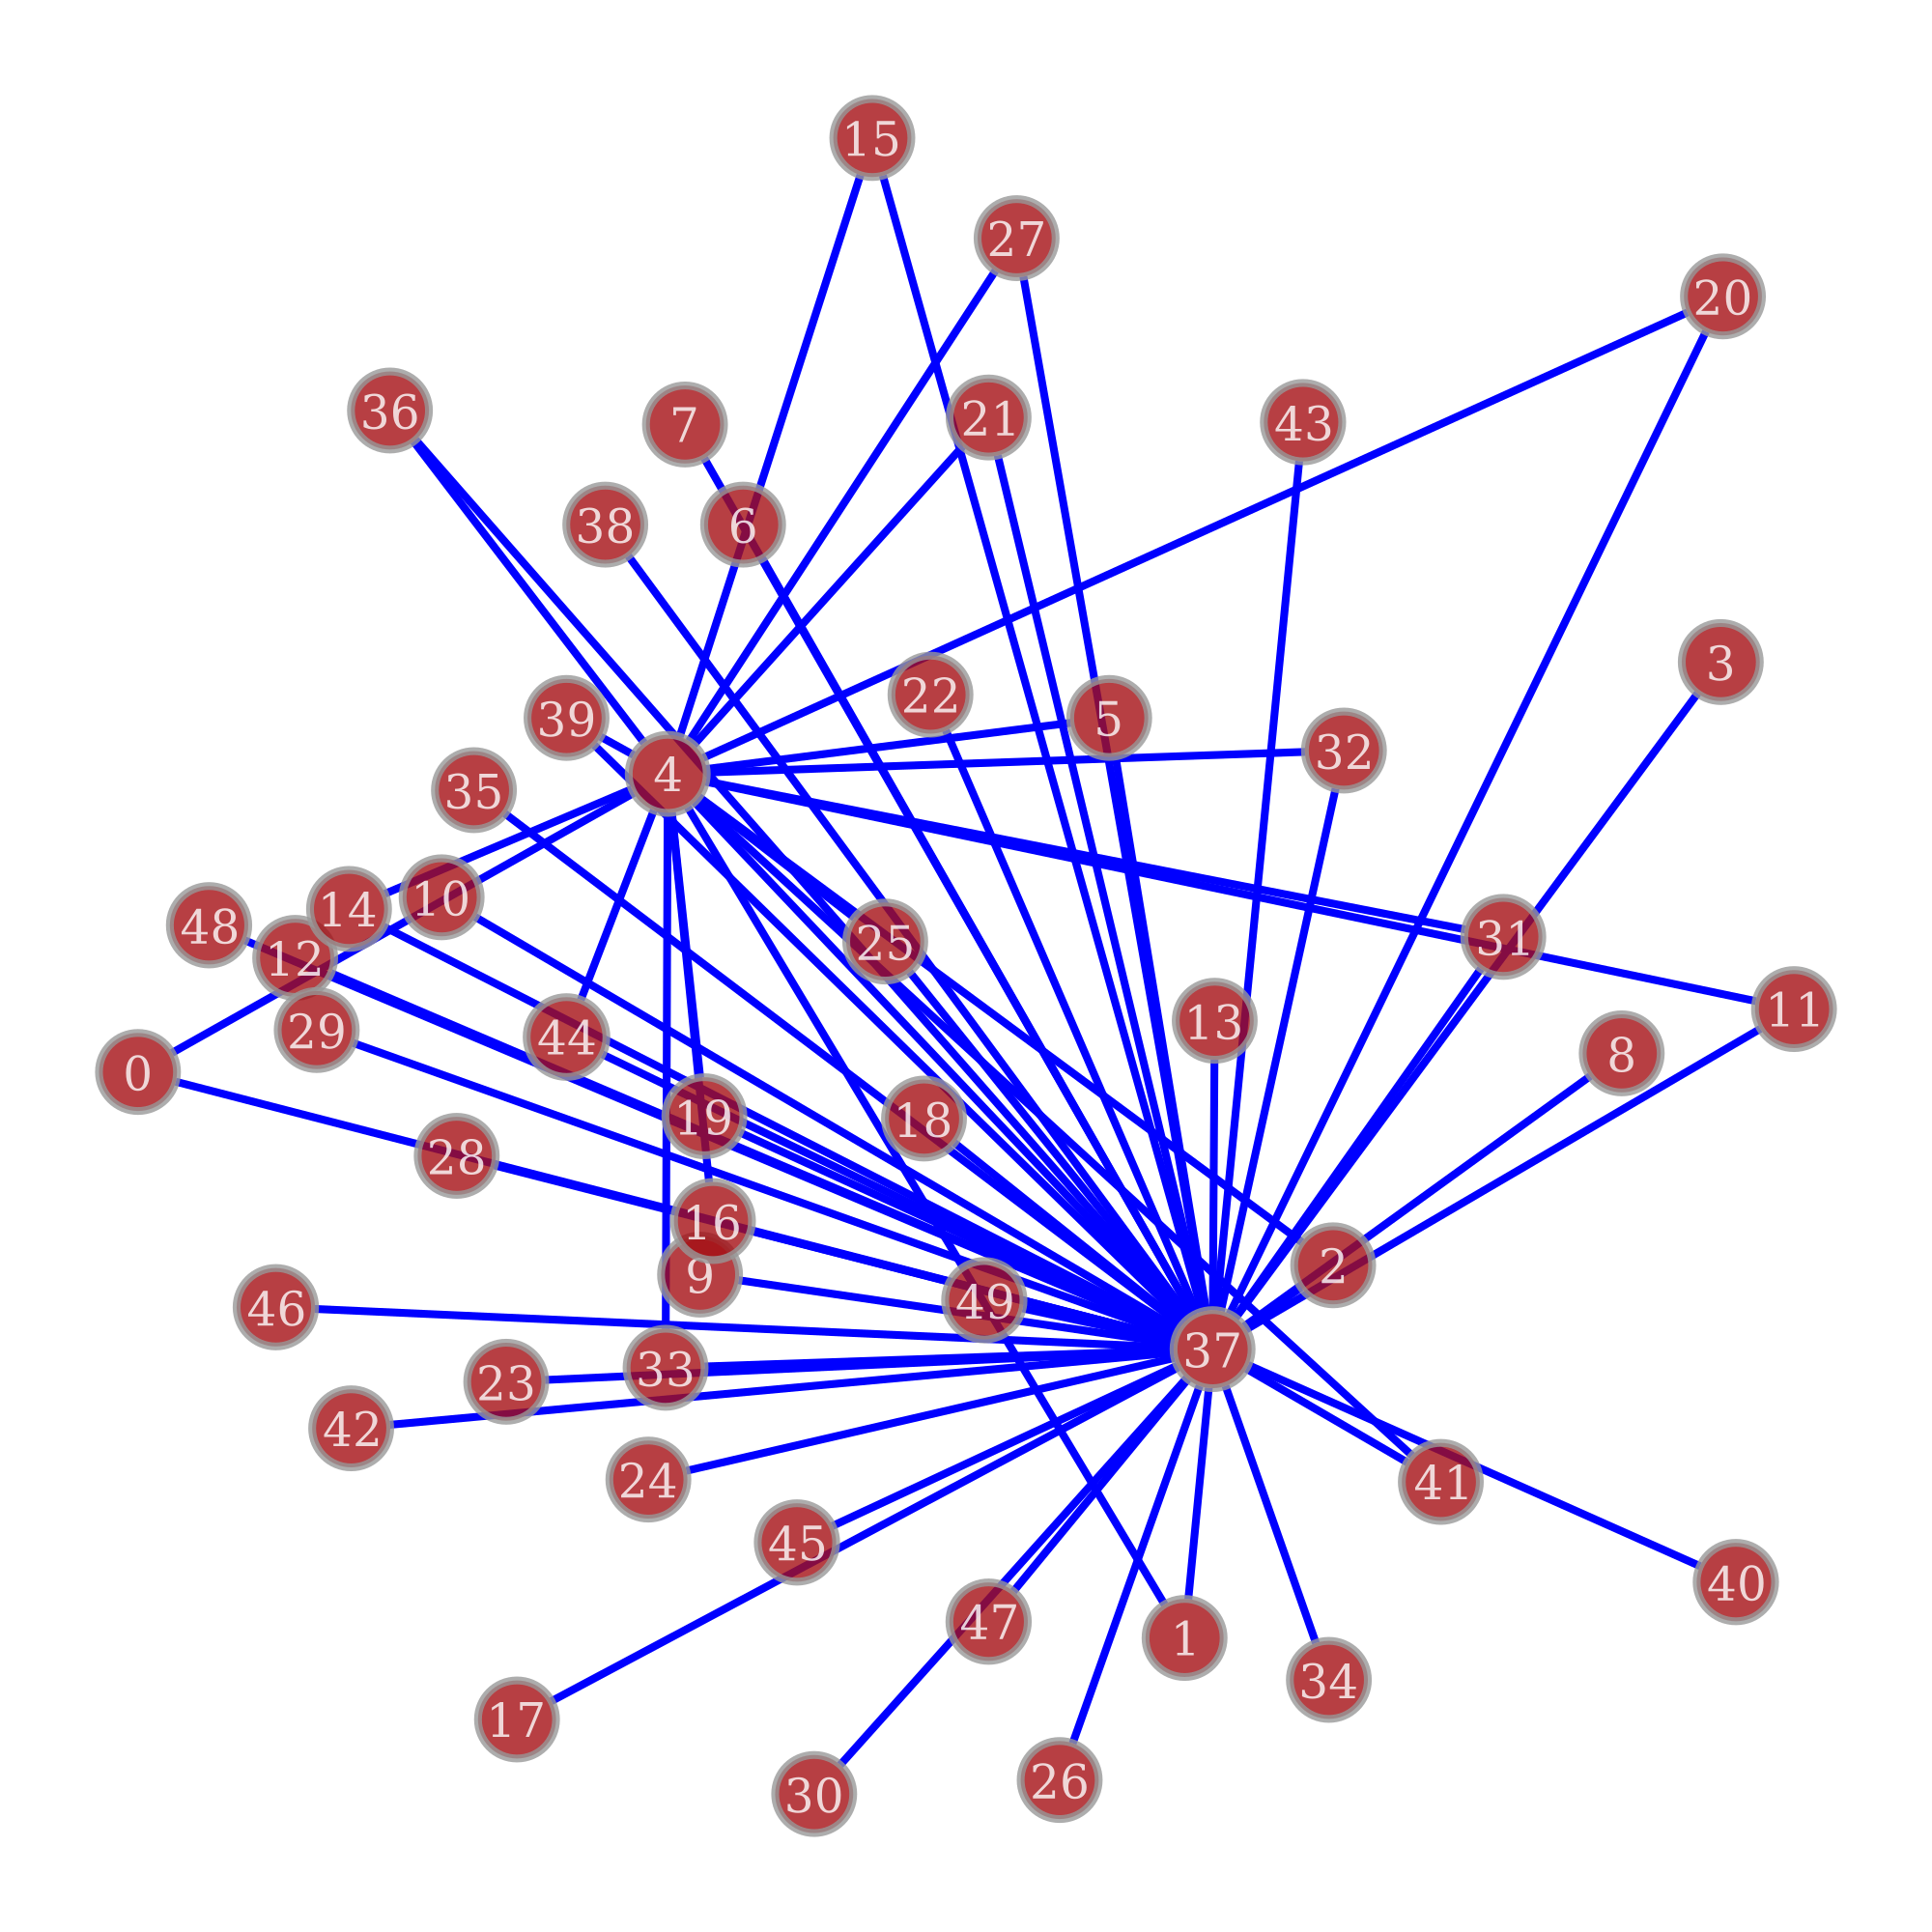

In [3]:
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import numpy as np
import random

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图　個体をグラフにデコードする
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                graph.add_edge(graph.vertex(i), graph.vertex(j))
    return graph

# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != 69:  # 边数限制，确保边数为69　エッジ数制限、エッジ数を69にする
        return float('inf'),  # 如果边数不为69，适应度设为无穷大　エッジ数が69でない場合、適応度を無限大に設定
    dist_matrix = shortest_distance(graph).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,

# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))
    return new_ind1, new_ind2

# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))  
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]
    
    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0
        
        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数为69　初期個体を初期化する際にエッジ数を69に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], 69)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)

# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)


    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1000, stats=stats, halloffame=hof, verbose=True)
    return pop, stats, hof

if __name__ == "__main__":
    pop, stats, hof = main()
    best_individual = hof[0]
    best_graph = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图　最終的に最適化されたグラフを描画する
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))


In [4]:
graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000),output=f'./output_GA_deap/{filename1}.png')

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb572a10e00, at 0x7fb562ecc590>

In [3]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0])**2 + (source_pos[1] - target_pos[1])**2)
    edge_weights[edge] = euclidean_distance

# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt((source_pos[0] - target_pos[0])**2 + (source_pos[1] - target_pos[1])**2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights

# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != 69:  # 边数限制，确保边数为69　エッジ数制限、エッジ数を69にする
        return float('inf'),  # 如果边数不为69，适应度设为无穷大　エッジ数が69でない場合、適応度を無限大に設定
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,

# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))
    return new_ind1, new_ind2

# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]
    
    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0
        
        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数为69　初期個体を初期化する際にエッジ数を69に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], 69)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)

# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1000, stats=stats, halloffame=hof, verbose=True)
    return pop, stats, hof

if __name__ == "__main__":
    pop, stats, hof = main()
    best_individual = hof[0]
    best_graph, _ = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图　最終的に最適化されたグラフを描画する
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))


nodes:  50 links  69


/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


gen	nevals	min     
0  	300   	4,211.23
1  	186   	4,214.58
2  	172   	4,214.58
3  	204   	4,136.73
4  	188   	4,136.73
5  	187   	4,030.05
6  	183   	4,030.05
7  	175   	4,030.05
8  	187   	4,030.05
9  	167   	3,910.98
10 	194   	3,888.46
11 	187   	3,888.46
12 	180   	3,888.46
13 	152   	3,873.12
14 	161   	3,871   
15 	164   	3,787.84
16 	182   	3,744.5 
17 	169   	3,697.06
18 	203   	3,634.49
19 	184   	3,604.51
20 	189   	3,574.58
21 	178   	3,531.21
22 	181   	3,477.86
23 	178   	3,477.86
24 	178   	3,477.86
25 	189   	3,454.33
26 	198   	3,394.14
27 	170   	3,457.44
28 	189   	3,309.95
29 	169   	3,309.95
30 	179   	3,243.98
31 	190   	3,243.98
32 	186   	3,308.15
33 	179   	3,293.29
34 	167   	3,255.65
35 	189   	3,255.65
36 	176   	3,240.89
37 	168   	3,214.48
38 	165   	3,130.46
39 	182   	3,130.46
40 	186   	3,096.14
41 	170   	3,074.42
42 	191   	3,005.93
43 	180   	3,005.93
44 	182   	3,005.93
45 	180   	3,005.93
46 	190   	2,995.68
47 	191   	3,005.93
48 	182   	2,958.84


KeyboardInterrupt: 

nodes:  50 links  69
gen	nevals	min     
0  	200   	3,603.75
1  	126   	3,603.75
2  	122   	3,603.75
3  	129   	3,603.75
4  	122   	3,596.25
5  	131   	3,571.59
6  	107   	3,561.52
7  	126   	3,447.86
8  	124   	3,447.86
9  	122   	3,372.48
10 	129   	3,372.48
11 	124   	3,260.82
12 	120   	3,260.82
13 	126   	3,260.82
14 	105   	3,198.18
15 	127   	3,195.76
16 	128   	3,177.17
17 	116   	3,175.78
18 	124   	3,067.11
19 	129   	3,083.89
20 	126   	3,083.89
21 	114   	3,008.48
22 	116   	2,960.42
23 	118   	2,960.42
24 	120   	2,960.42
25 	130   	2,946.35
26 	110   	2,869.59
27 	111   	2,869.59
28 	113   	2,869.59
29 	129   	2,816.55
30 	130   	2,816.05
31 	112   	2,799.37
32 	116   	2,769.24
33 	121   	2,784.45
34 	116   	2,726.72
35 	126   	2,726.72
36 	113   	2,726.72
37 	127   	2,726.72
38 	116   	2,705.26
39 	130   	2,693.44
40 	123   	2,682.18
41 	126   	2,682.18
42 	108   	2,618.39
43 	115   	2,612.67
44 	119   	2,579.58
45 	122   	2,566.78
46 	129   	2,566.78
47 	88    	2,544.94

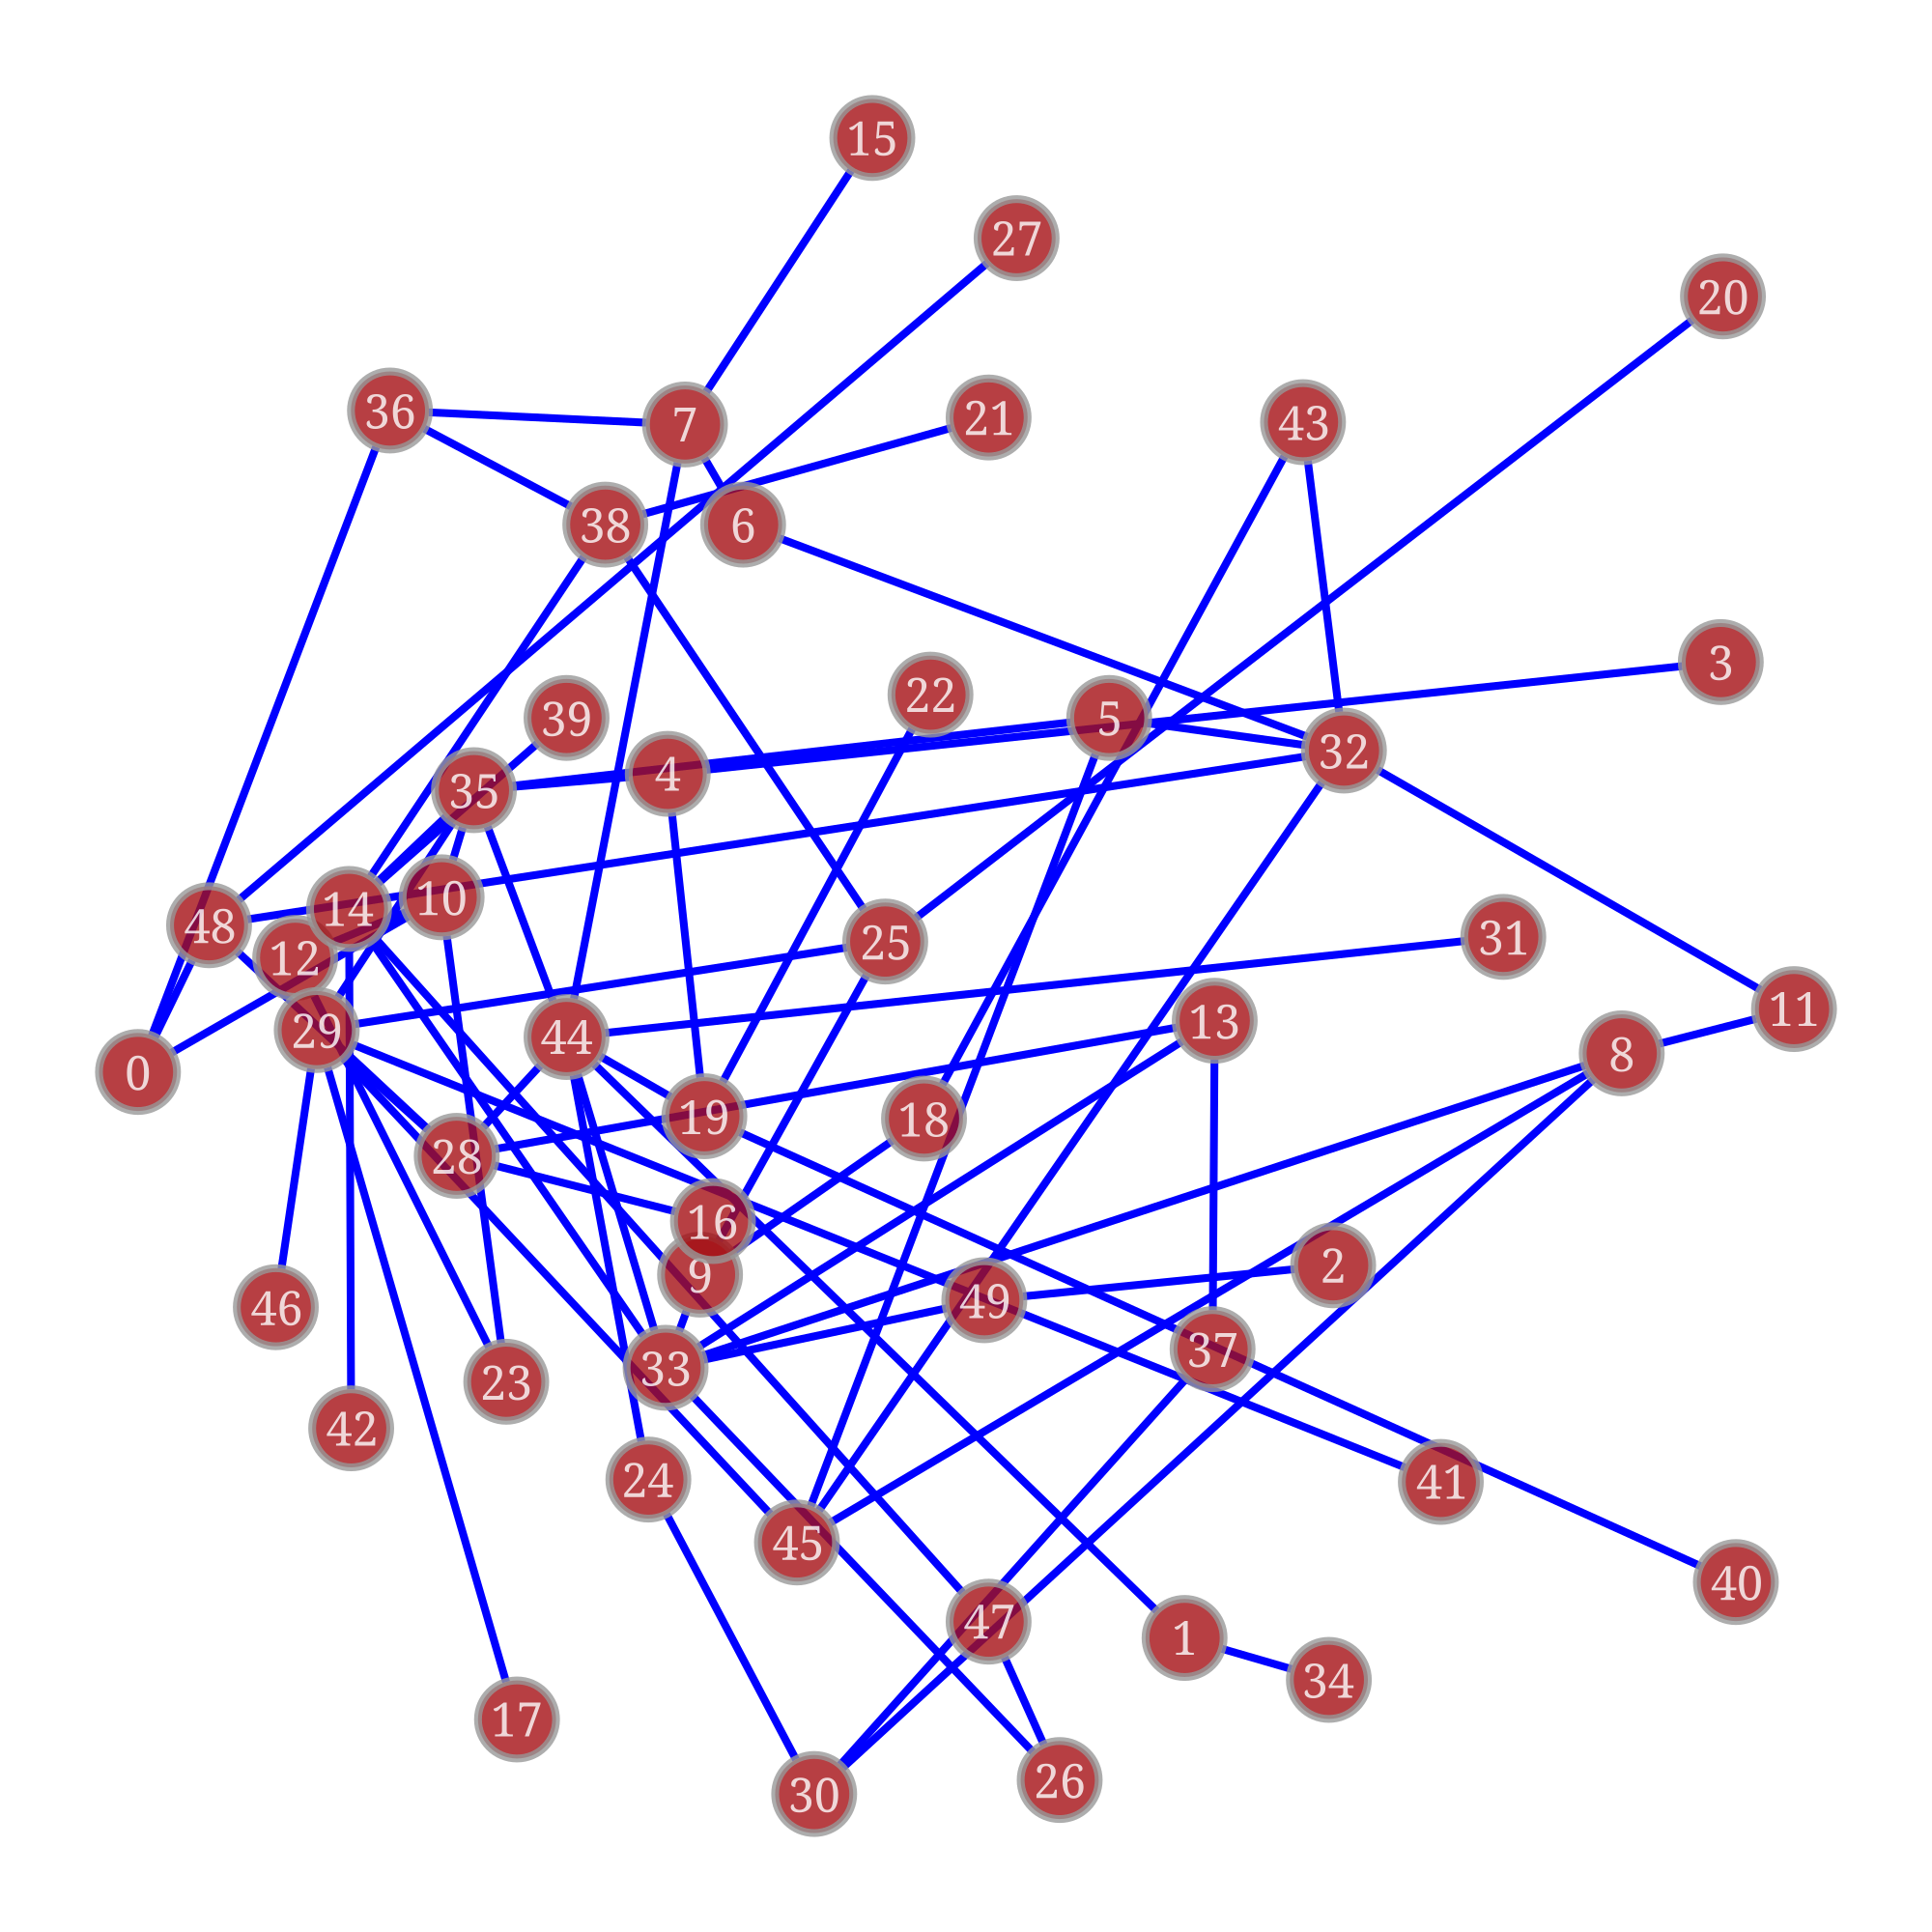

In [5]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != 69:  # 边数限制，确保边数为69　エッジ数制限、エッジ数を69にする
        return float('inf'),  # 如果边数不为69，适应度设为无穷大　エッジ数が69でない場合、適応度を無限大に設定
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))
    return new_ind1, new_ind2


# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为69　初期個体を初期化する際にエッジ数を69に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], 69)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main():
    pop = toolbox.population(n=200)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, stats=stats, halloffame=hof, verbose=True)
    return pop, stats, hof


if __name__ == "__main__":
    pop, stats, hof = main()
    best_individual = hof[0]
    best_graph, _ = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图　最終的に最適化されたグラフを描画する
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))


nodes:  50 links  69


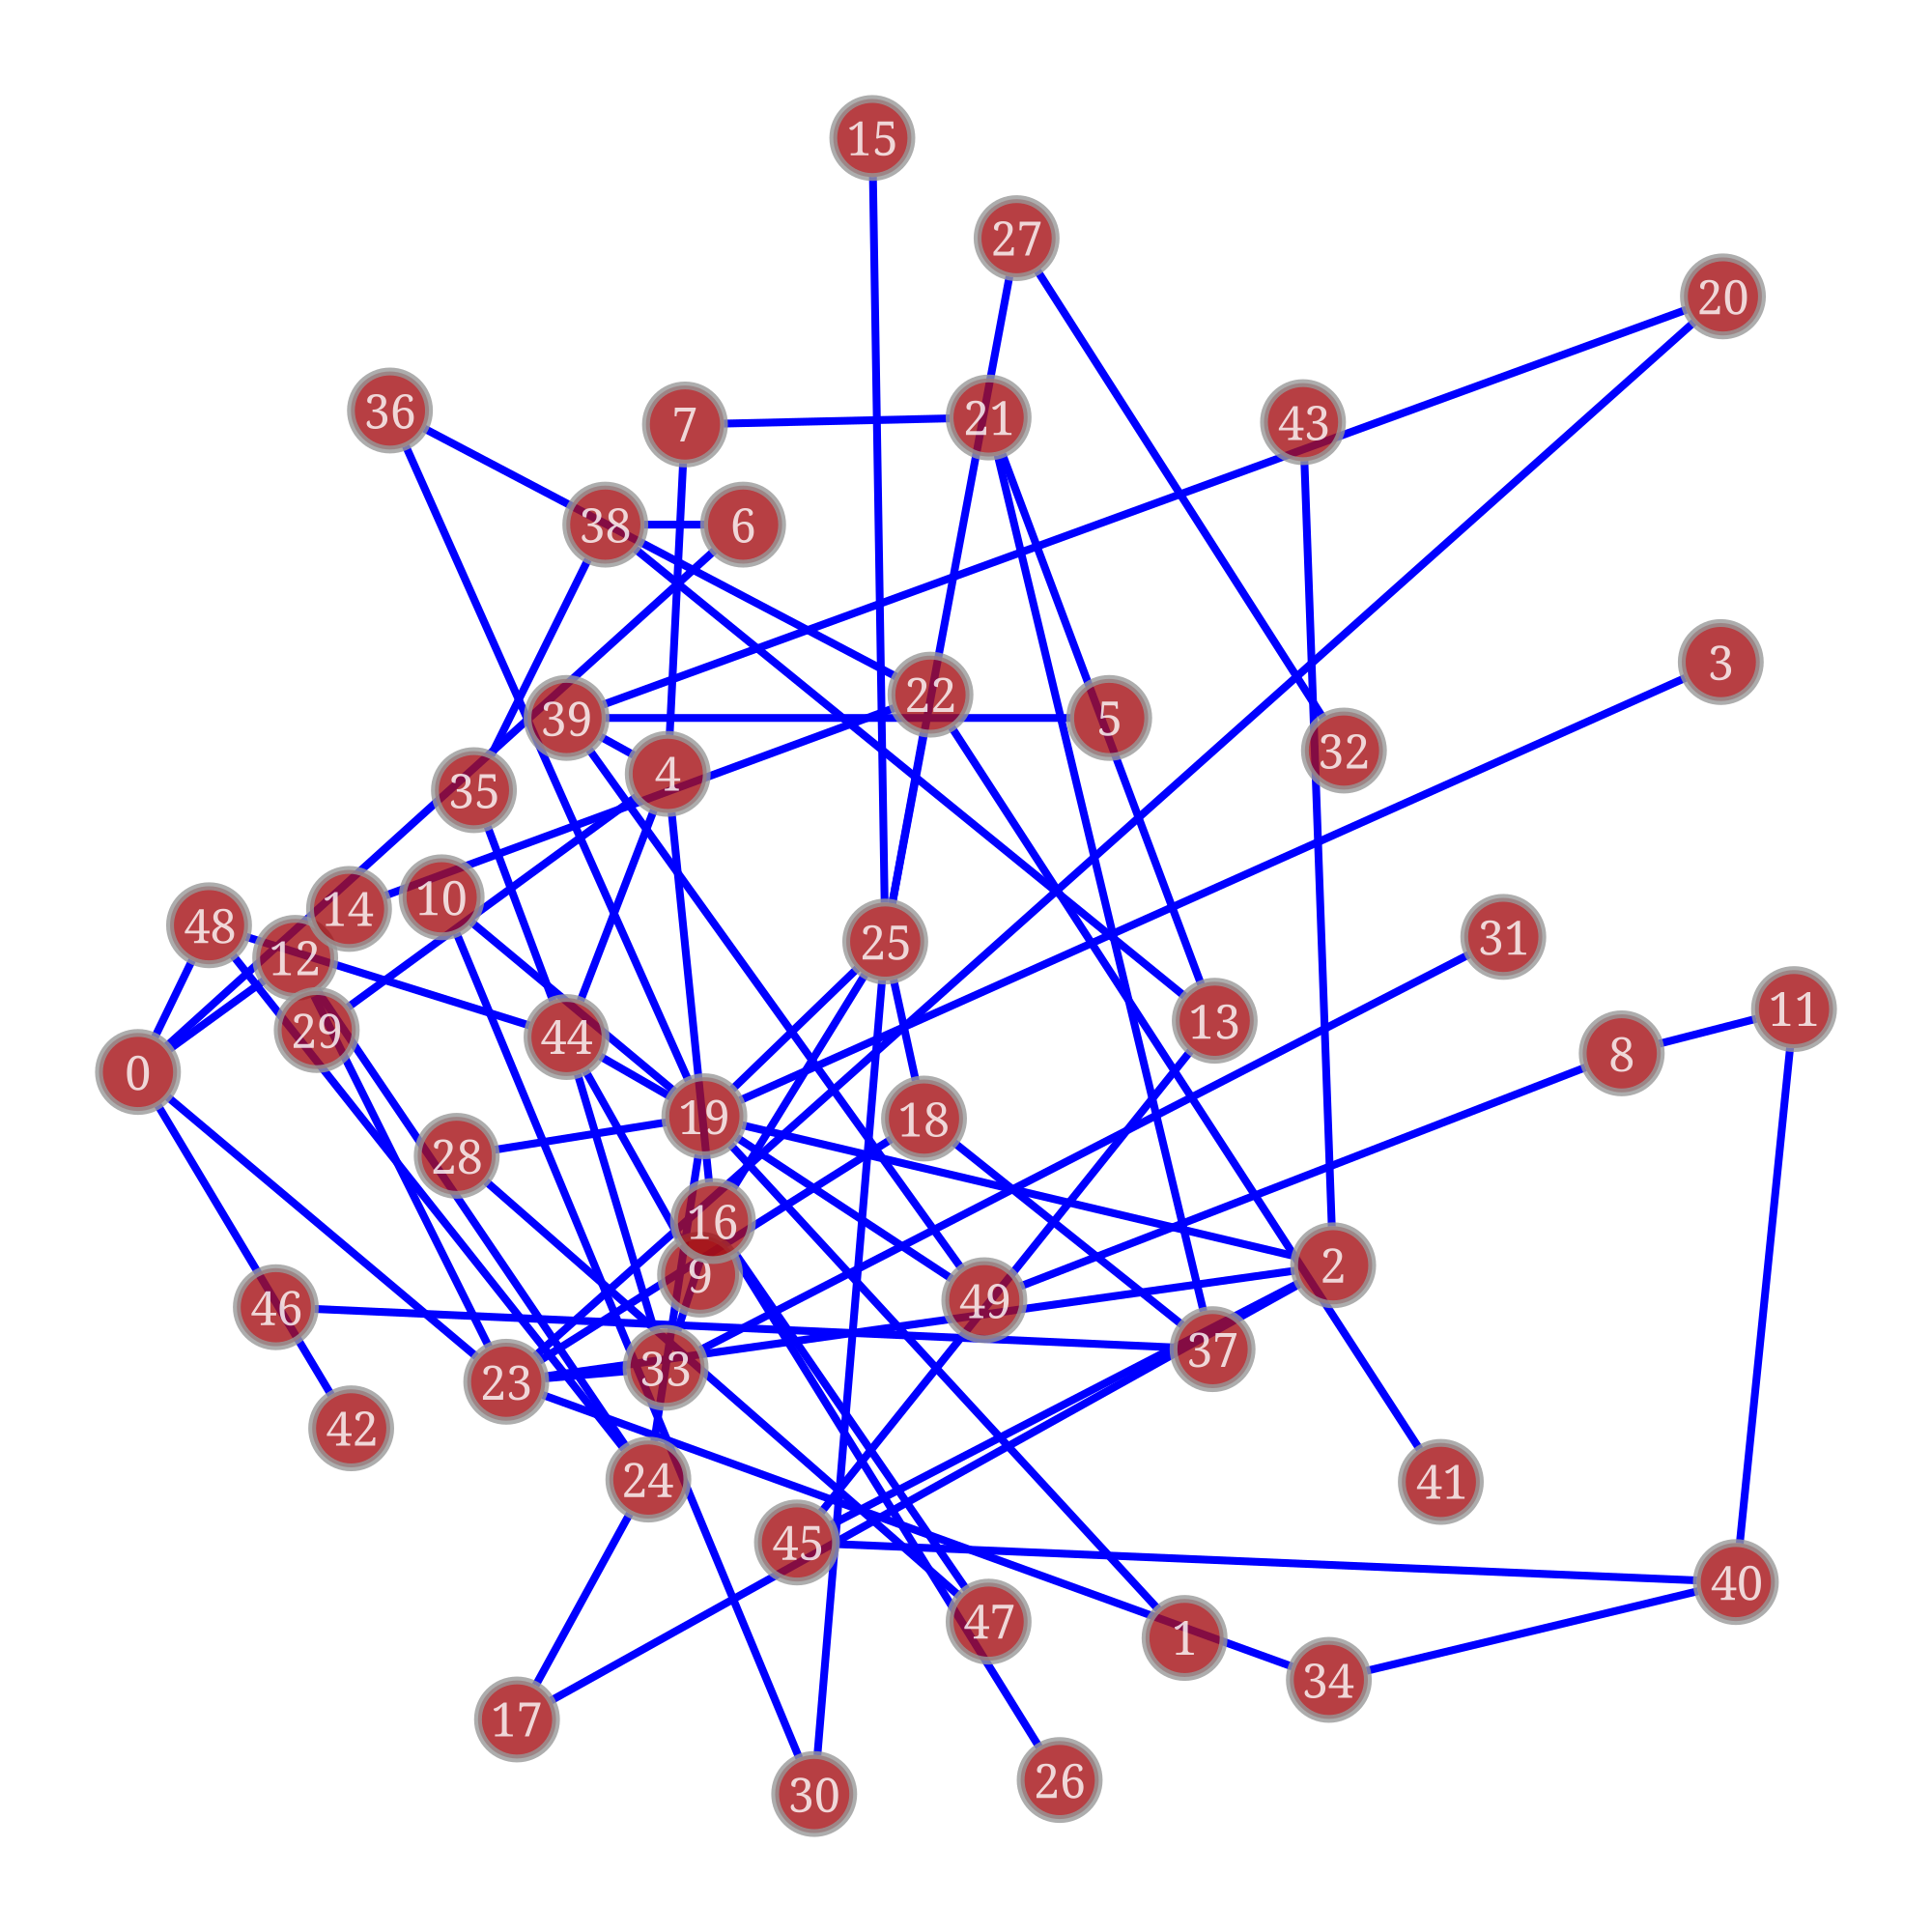

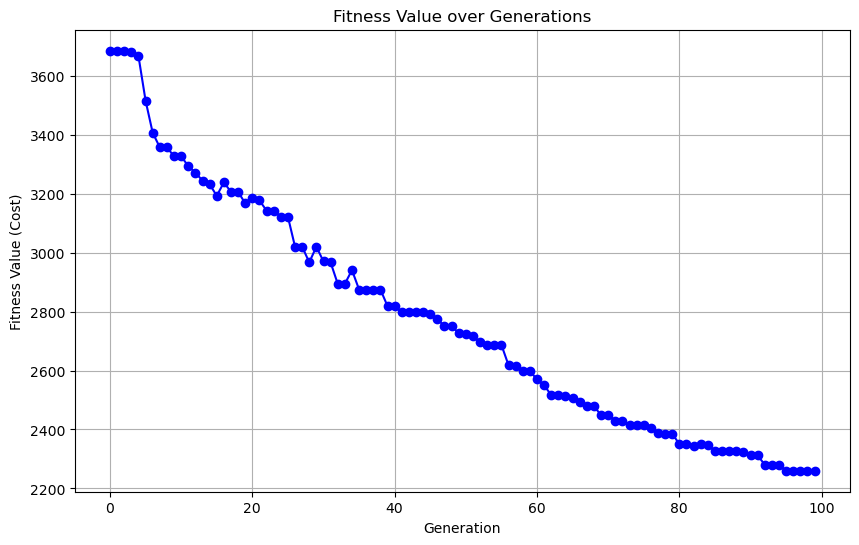

In [6]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != 69:  # 边数限制，确保边数为69　エッジ数制限、エッジ数を69にする
        return float('inf'),  # 如果边数不为69，适应度设为无穷大　エッジ数が69でない場合、適応度を無限大に設定
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))
    return new_ind1, new_ind2


# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为69　初期個体を初期化する際にエッジ数を69に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], 69)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main():
    pop = toolbox.population(n=200)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(100):  # 迭代100代
        pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, stats=stats, halloffame=hof,
                                     verbose=False)
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)

    return pop, logbook, hof


if __name__ == "__main__":
    pop, logbook, hof = main()
    best_individual = hof[0]
    best_graph, _ = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图　最終的に最適化されたグラフを描画する
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))

    # 绘制适应度值随迭代次数变化的图表
    min_fitness_values = logbook.select("min")
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(min_fitness_values)), min_fitness_values, marker='o', linestyle='-', color='b')
    plt.title("Fitness Value over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.grid(True)
    plt.show()


nodes:  50 links  69
Generation 0: Min Fitness 3837.300210377745
Generation 1: Min Fitness 3837.300210377745
Generation 2: Min Fitness 3837.300210377745
Generation 3: Min Fitness 3719.9282969572228
Generation 4: Min Fitness 3683.77992795458
Generation 5: Min Fitness 3662.776041395058
Generation 6: Min Fitness 3671.7652520204965
Generation 7: Min Fitness 3649.48831519013
Generation 8: Min Fitness 3653.39567758424
Generation 9: Min Fitness 3568.2483491172234
Generation 10: Min Fitness 3568.2483491172234
Generation 11: Min Fitness 3521.3901428436966
Generation 12: Min Fitness 3488.571174175239
Generation 13: Min Fitness 3427.2215162531584
Generation 14: Min Fitness 3365.719694437519
Generation 15: Min Fitness 3355.2184511829264
Generation 16: Min Fitness 3355.2184511829264
Generation 17: Min Fitness 3315.2342637978318
Generation 18: Min Fitness 3251.4244938350193
Generation 19: Min Fitness 3244.4724873482896
Generation 20: Min Fitness 3200.278734418402
Generation 21: Min Fitness 3200.2787

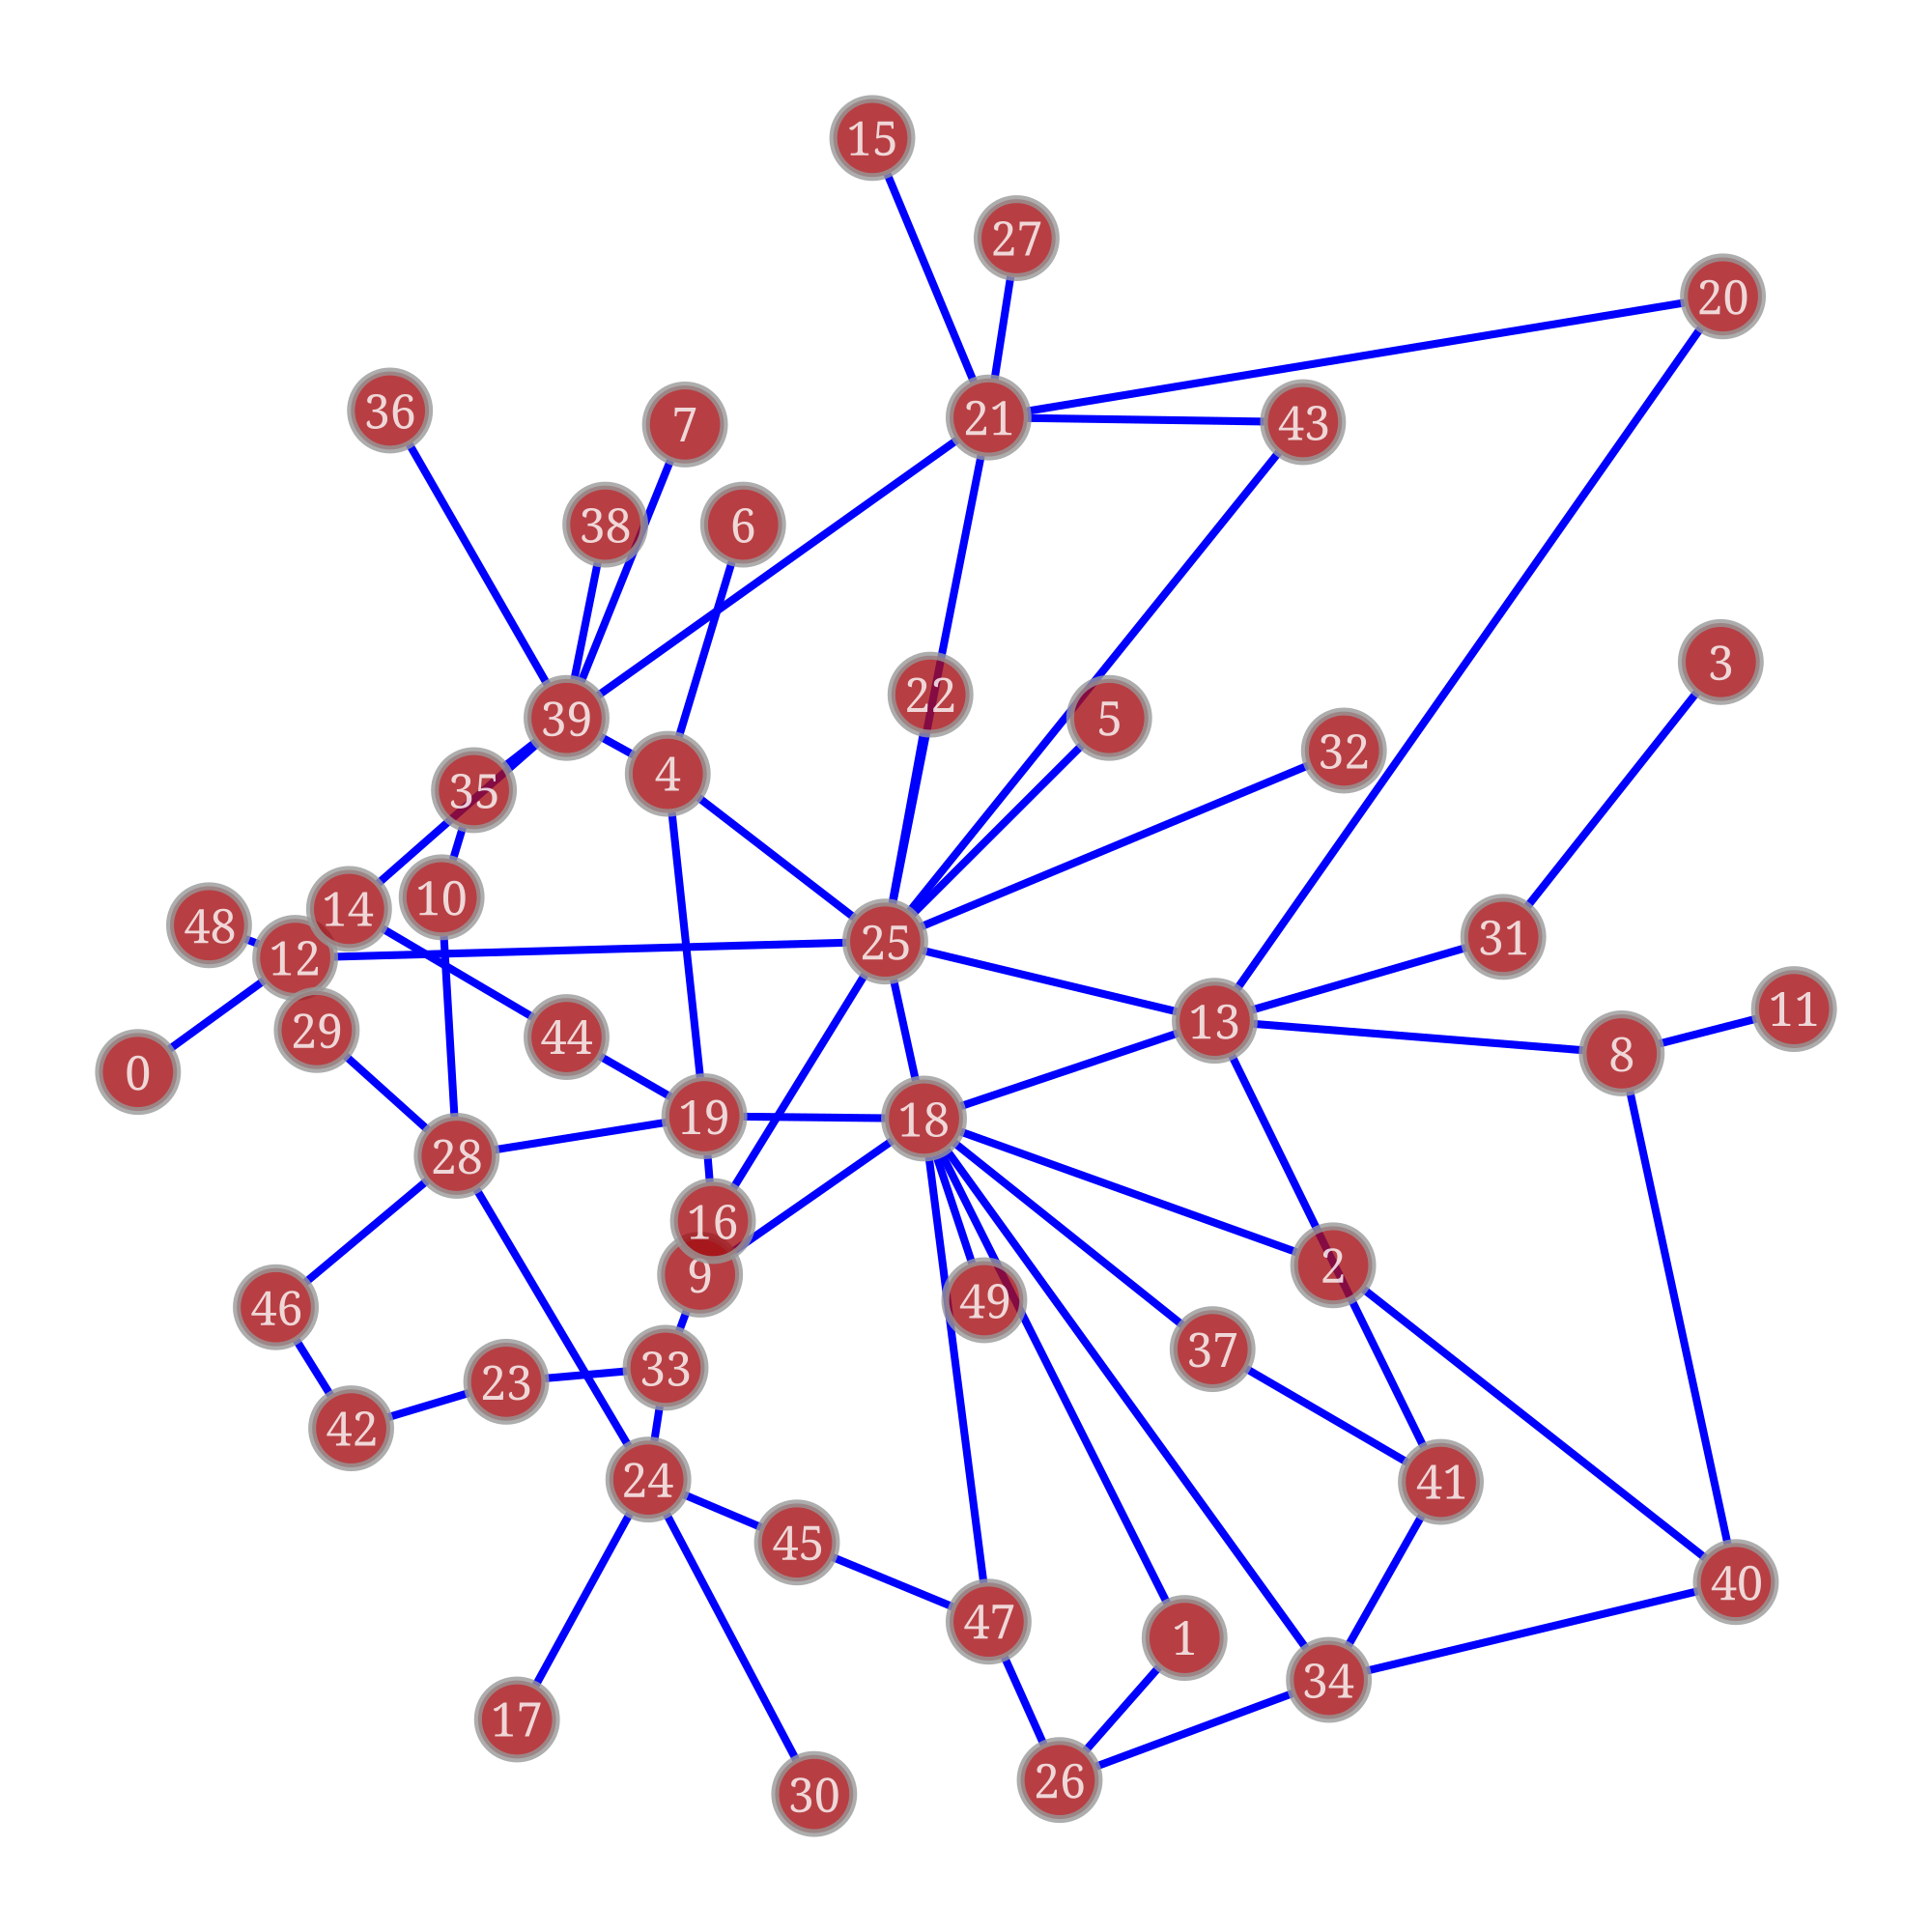

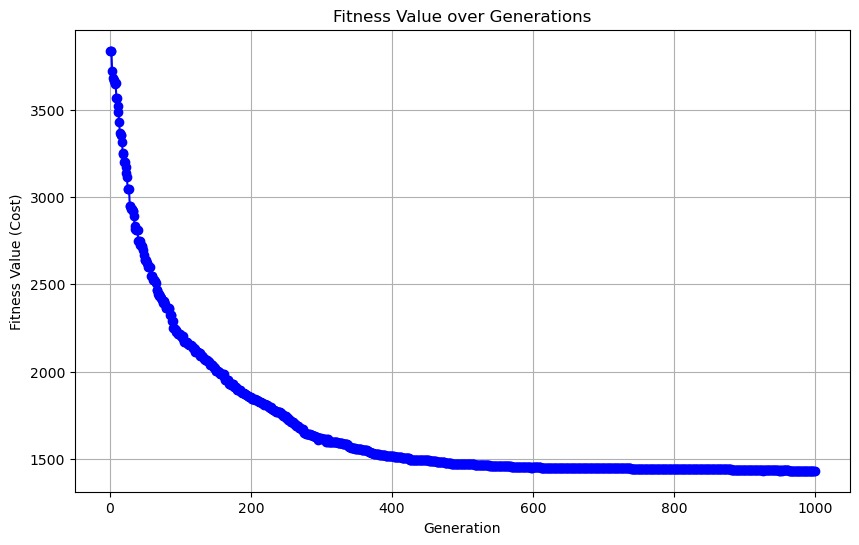

In [8]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != 69:  # 边数限制，确保边数为69　エッジ数制限、エッジ数を69にする
        return float('inf'),  # 如果边数不为69，适应度设为无穷大　エッジ数が69でない場合、適応度を無限大に設定
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))
    return new_ind1, new_ind2


# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为69　初期個体を初期化する際にエッジ数を69に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], 69)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(1000):  # 迭代100代
        pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, stats=stats, halloffame=hof,
                                     verbose=False)
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

    return pop, logbook, hof


if __name__ == "__main__":
    pop, logbook, hof = main()
    best_individual = hof[0]
    best_graph, _ = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图　最終的に最適化されたグラフを描画する
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))

    # 绘制适应度值随迭代次数变化的图表
    min_fitness_values = logbook.select("min")
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(min_fitness_values)), min_fitness_values, marker='o', linestyle='-', color='b')
    plt.title("Fitness Value over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.grid(True)
    plt.show()


In [9]:
graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000), output=f'./output_O/{filename1}.png')
plt.savefig(f"./output_O/fitness_over_generations.png")

<Figure size 640x480 with 0 Axes>

nodes:  50 links  69
Generation 0: Min Fitness 3552.2229818334313
Generation 1: Min Fitness 3495.6097920919633
Generation 2: Min Fitness 3386.5085426821806
Generation 3: Min Fitness 3386.5085426821806
Generation 4: Min Fitness 3315.8350951370626
Generation 5: Min Fitness 3276.8138907776106
Generation 6: Min Fitness 3168.1330367631017
Generation 7: Min Fitness 3133.2583129931327
Generation 8: Min Fitness 3072.9482966042538
Generation 9: Min Fitness 3013.243435411481
Generation 10: Min Fitness 2939.4108331913367
Generation 11: Min Fitness 2926.2778027381755
Generation 12: Min Fitness 2901.7630461667254
Generation 13: Min Fitness 2871.201626948333
Generation 14: Min Fitness 2868.7487847462735
Generation 15: Min Fitness 2738.898690166339
Generation 16: Min Fitness 2738.898690166339
Generation 17: Min Fitness 2725.196190495635
Generation 18: Min Fitness 2643.6684026463327
Generation 19: Min Fitness 2565.7253957022617
Generation 20: Min Fitness 2510.9227316393954
Generation 21: Min Fitness 2

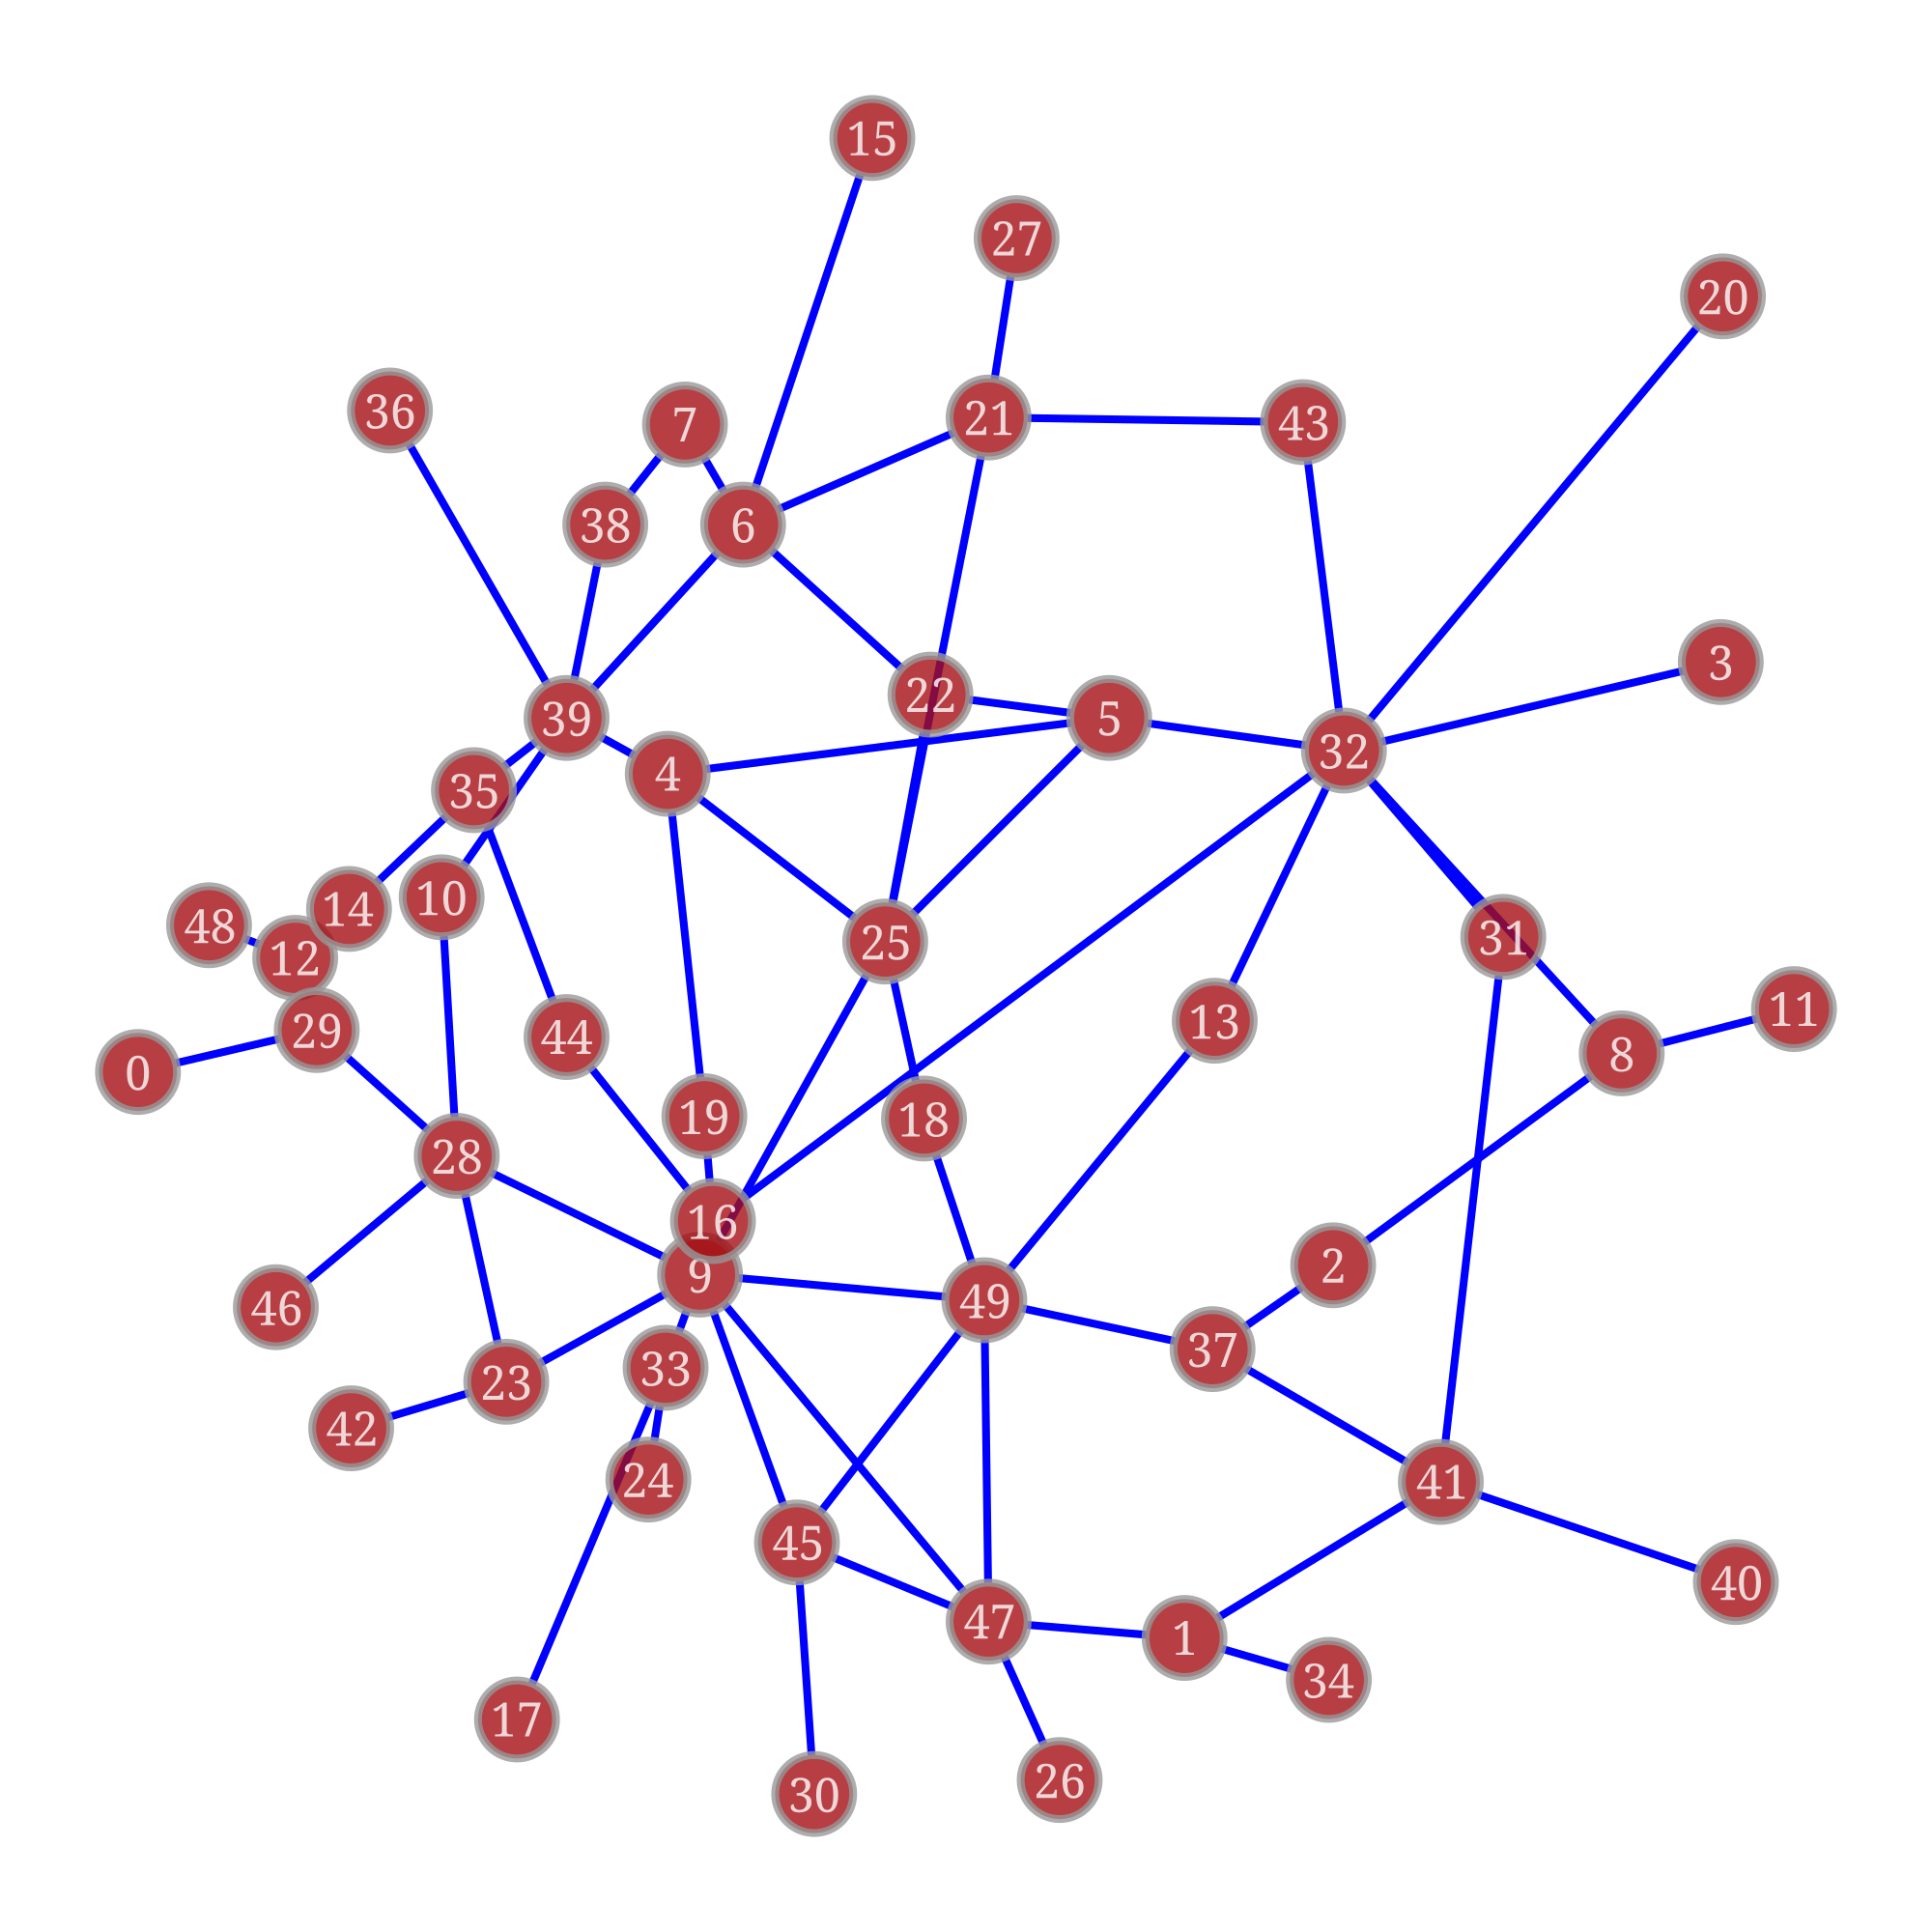

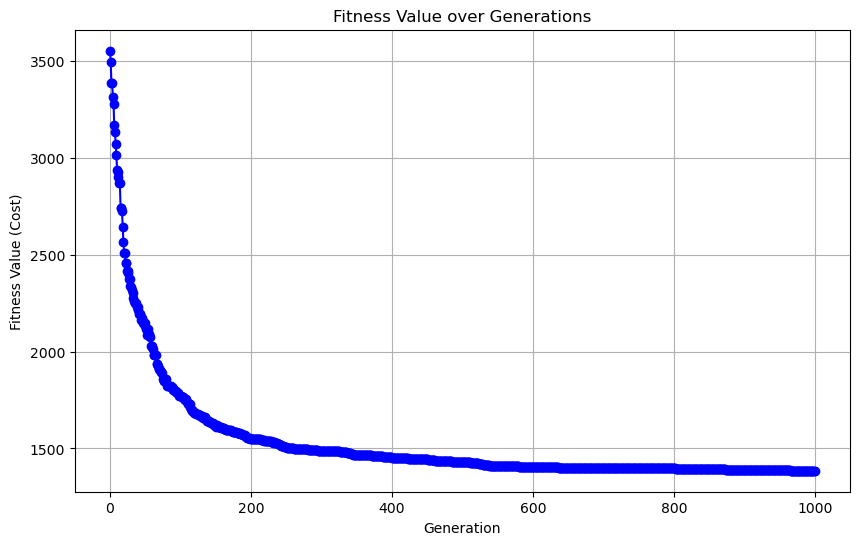

In [12]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != 69:  # 边数限制，确保边数为69　エッジ数制限、エッジ数を69にする
        return float('inf'),  # 如果边数不为69，适应度设为无穷大　エッジ数が69でない場合、適応度を無限大に設定
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > 69:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - 69)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < 69:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, 69 - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为69　初期個体を初期化する際にエッジ数を69に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], 69)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(1000): 
        pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, stats=stats, halloffame=hof,
                                     verbose=False)
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

    return pop, logbook, hof


if __name__ == "__main__":
    pop, logbook, hof = main()
    best_individual = hof[0]
    best_graph, _ = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图　最終的に最適化されたグラフを描画する
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000), output=f'./output_O/{filename1}.png')
    # 绘制适应度值随迭代次数变化的图表
    min_fitness_values = logbook.select("min")
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(min_fitness_values)), min_fitness_values, marker='o', linestyle='-', color='b')
    plt.title("Fitness Value over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.grid(True)
    plt.savefig(f"./output_O/fitness_over_generations.png")
    plt.show()


nodes:  50 links  69
Generation 0: Min Fitness 3806.7075593540667
Generation 1: Min Fitness 3538.2850398260643
Generation 2: Min Fitness 3404.0919691361887
Generation 3: Min Fitness 3404.0919691361887
Generation 4: Min Fitness 3334.6530464500493
Generation 5: Min Fitness 3324.4500067461286
Generation 6: Min Fitness 3175.675484723485
Generation 7: Min Fitness 3175.675484723485
Generation 8: Min Fitness 3089.3272328057237
Generation 9: Min Fitness 3089.3272328057237
Generation 10: Min Fitness 3016.951931772919
Generation 11: Min Fitness 2894.8231606486365
Generation 12: Min Fitness 2848.9013457392175
Generation 13: Min Fitness 2703.4356447413484
Generation 14: Min Fitness 2711.8048101436725
Generation 15: Min Fitness 2711.8048101436725
Generation 16: Min Fitness 2637.5053600707315
Generation 17: Min Fitness 2612.2521325395282
Generation 18: Min Fitness 2569.015700404134
Generation 19: Min Fitness 2517.1407773950837
Generation 20: Min Fitness 2517.1407773950837
Generation 21: Min Fitness 

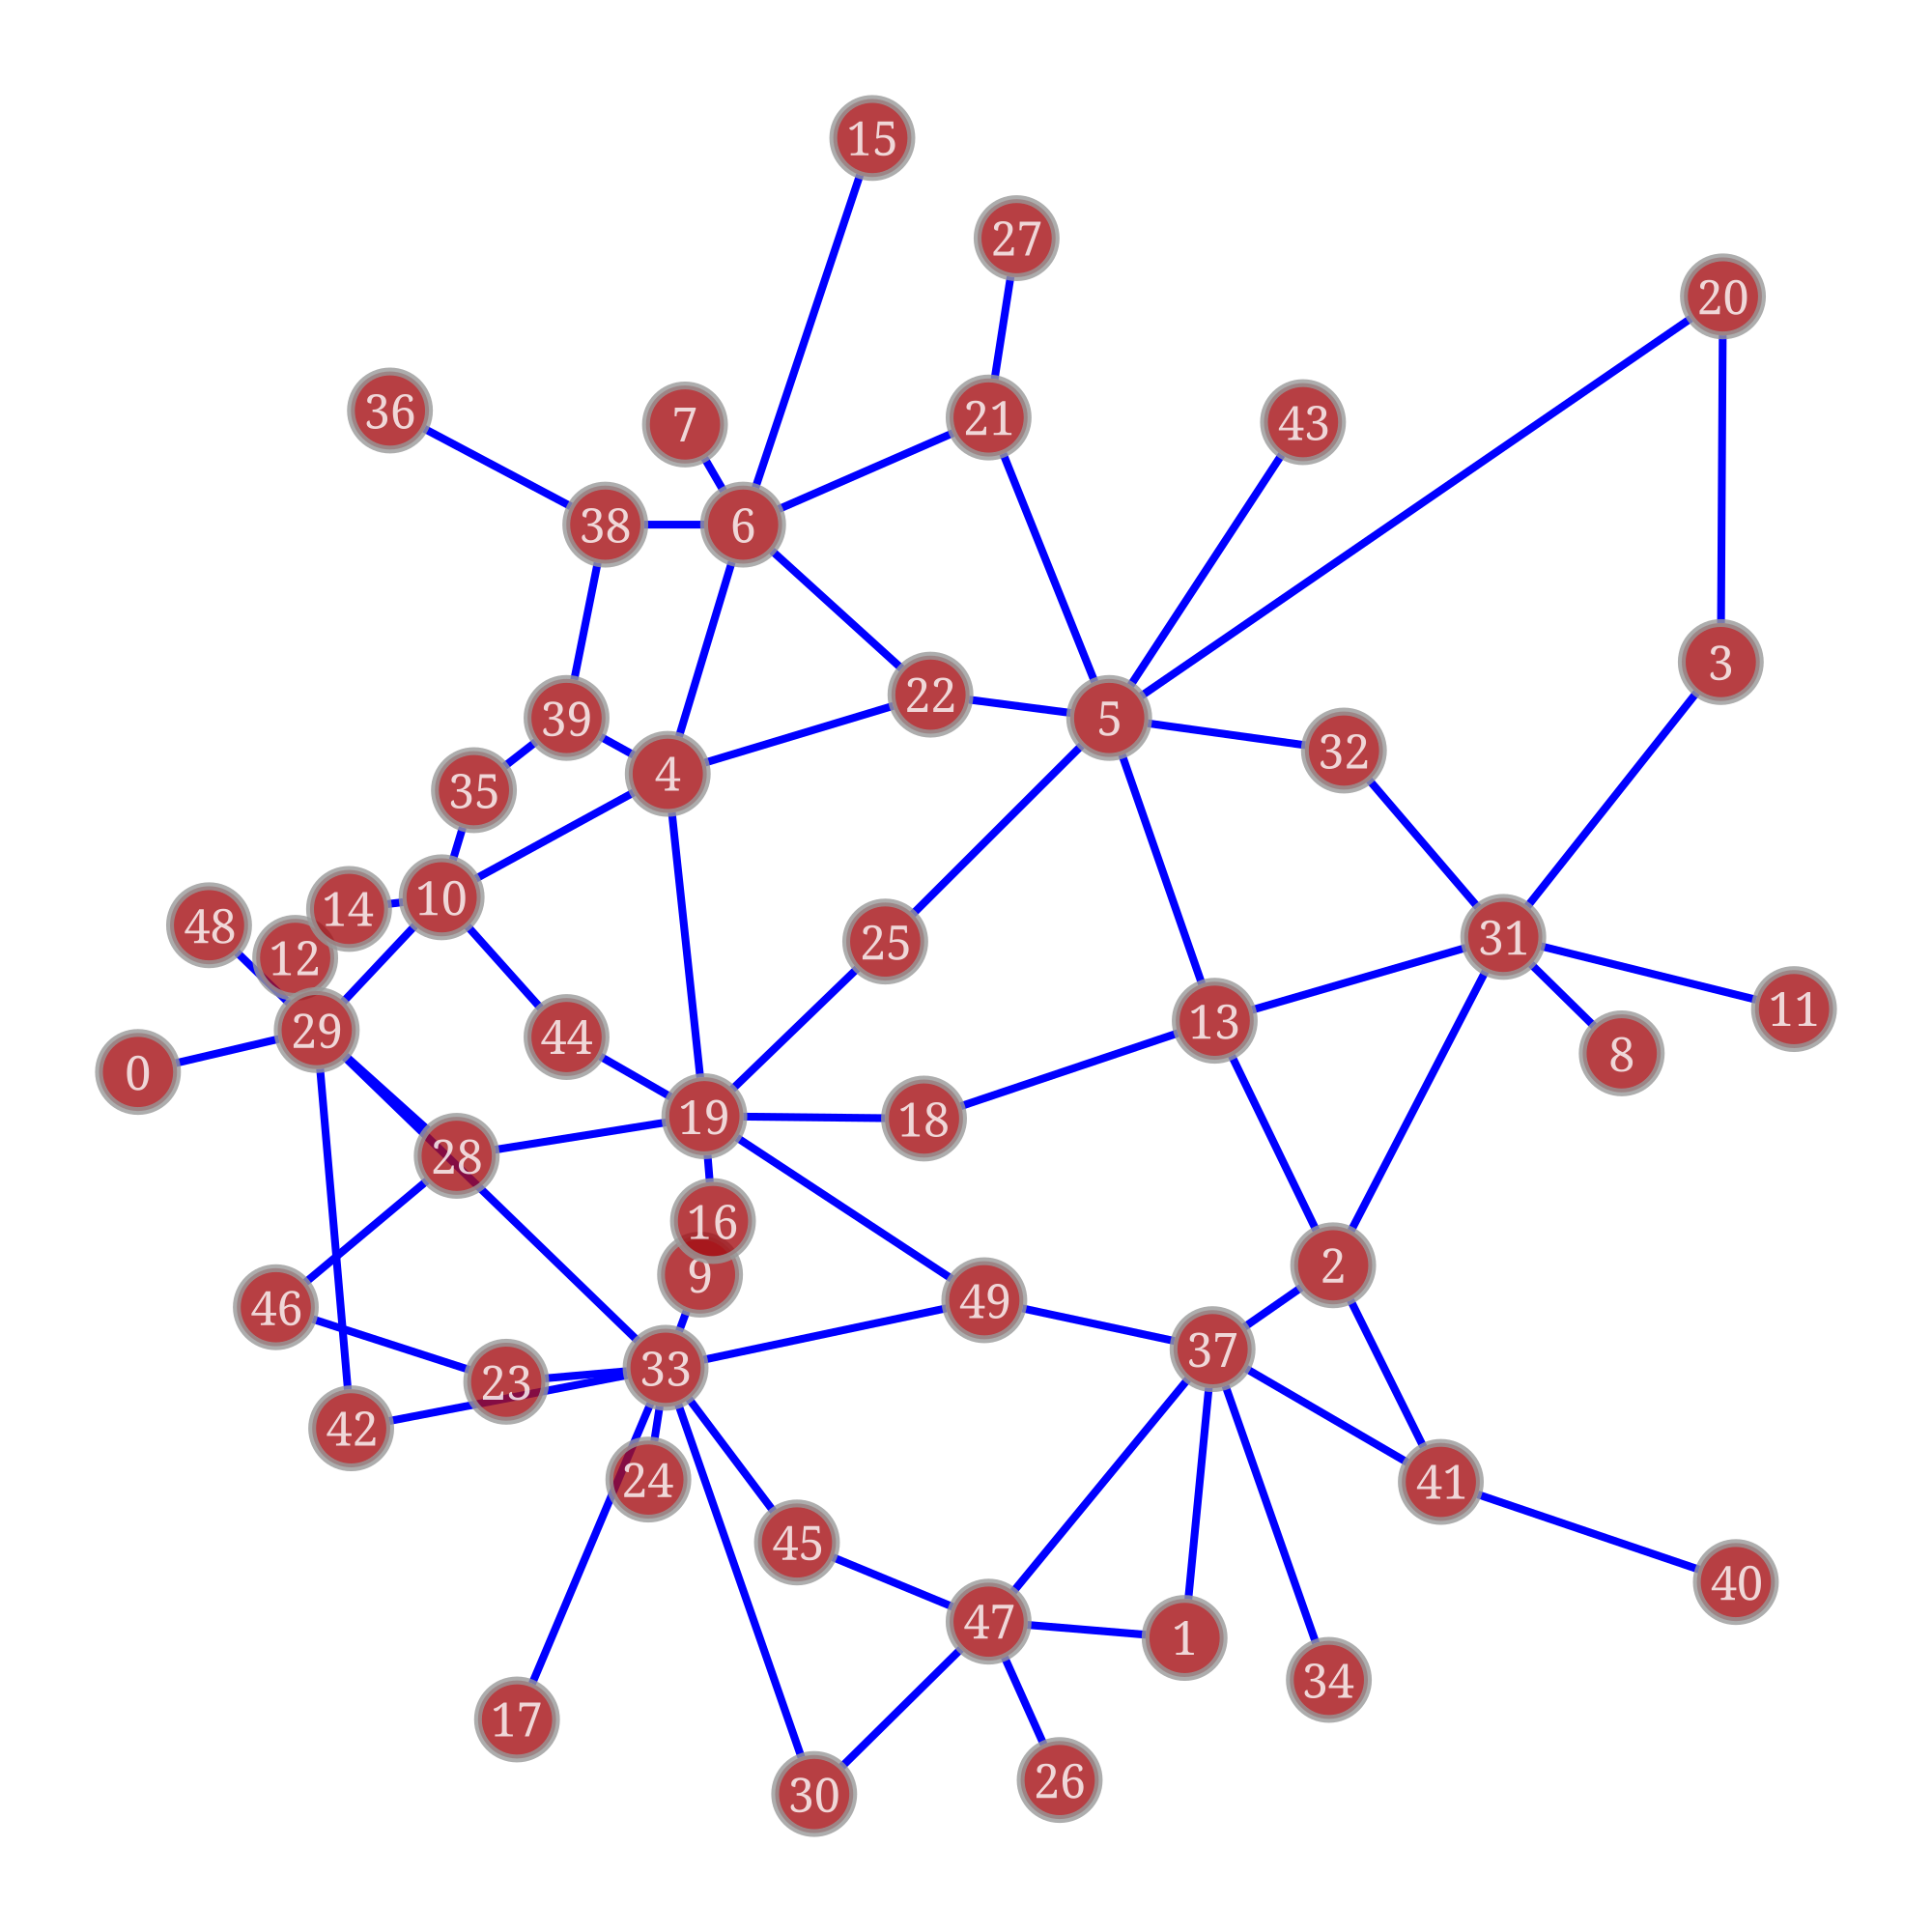

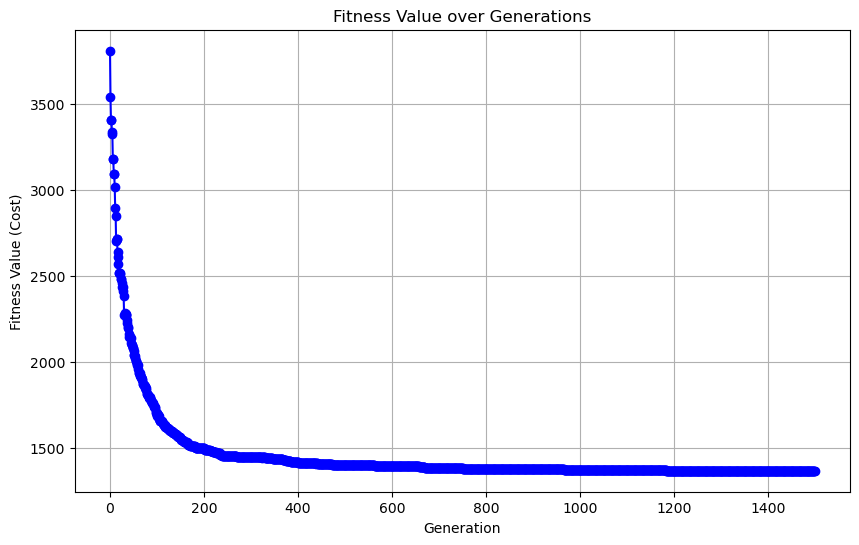

In [13]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != 69:  # 边数限制，确保边数为69　エッジ数制限、エッジ数を69にする
        return float('inf'),  # 如果边数不为69，适应度设为无穷大　エッジ数が69でない場合、適応度を無限大に設定
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > 69:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - 69)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < 69:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, 69 - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为69　初期個体を初期化する際にエッジ数を69に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], 69)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(1500):
        pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, stats=stats, halloffame=hof,
                                     verbose=False)
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

    return pop, logbook, hof


if __name__ == "__main__":
    pop, logbook, hof = main()
    best_individual = hof[0]
    best_graph, _ = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图　最終的に最適化されたグラフを描画する
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000),
               output=f'./output_O/{filename1}.png')
    # 绘制适应度值随迭代次数变化的图表
    min_fitness_values = logbook.select("min")
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(min_fitness_values)), min_fitness_values, marker='o', linestyle='-', color='b')
    plt.title("Fitness Value over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.grid(True)
    plt.savefig(f"./output_O/fitness_over_generations.png")
    plt.show()


In [12]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图和位置信息 グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 将图转换为个体编码 グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图并计算边权重属性 個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights

# 定义适应度函数 適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != 69:  # 边数限制，确保边数为69 エッジ数制限、エッジ数を69にする
        return float('inf')  # 如果边数不为69，适应度设为无穷大 エッジ数が69でない場合、適応度を無限大に設定
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance

# 自定义交叉操作 交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > 69:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - 69)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < 69:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, 69 - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2

# 自定义变异操作 変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边 エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边 エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置 遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数为69 初期個体を初期化する際にエッジ数を69に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], 69)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selBest, k=150)  # 选择最好的150个个体

# 主遗传算法流程 メイン遺伝的アルゴリズムフロー
def main():
    pop = toolbox.population(n=300)  # 初始种群数量为300
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(1500):
        # 计算当前种群的适应度
        fitnesses = map(toolbox.evaluate, pop)
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = (fit,)

        # 从当前种群中选择适应度最好的150个个体
        selected_pop = toolbox.select(pop)

        # 生成新的种群，大小为300
        offspring = algorithms.varAnd(selected_pop, toolbox, cxpb=0.5, mutpb=0.2)
        pop = selected_pop + offspring

        # 调试信息：输出当前代的种群数量和最小适应度值
        #print(f"Generation {gen}: Number of individuals in population: {len(pop)}")
        
        record = stats.compile(selected_pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

    return pop, logbook, hof

if __name__ == "__main__":
    pop, logbook, hof = main()
    best_individual = hof[0]
    best_graph, _ = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图 最終のに最適化されたグラフを描画する
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000),
               output=f'./output_O/{filename1}01.png')

    # 绘制适应度值随迭代次数变化的图表
    min_fitness_values = logbook.select("min")
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(min_fitness_values)), min_fitness_values, marker='o', linestyle='-', color='b')
    plt.title("Fitness Value over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.grid(True)
    plt.savefig(f"./output_O/fitness_over_generations01.png")
    plt.show()


nodes:  50 links  69
Generation 0: Min Fitness 3897.4172095565045
Generation 1: Min Fitness 3858.308409357248
Generation 2: Min Fitness 3713.7964547265883
Generation 3: Min Fitness 3643.1776846356033
Generation 4: Min Fitness 3643.1776846356033
Generation 5: Min Fitness 3643.1776846356033
Generation 6: Min Fitness 3643.1776846356033
Generation 7: Min Fitness 3643.1776846356033
Generation 8: Min Fitness 3643.1776846356033
Generation 9: Min Fitness 3542.1465214346836
Generation 10: Min Fitness 3542.1465214346836
Generation 11: Min Fitness 3507.3660013488293
Generation 12: Min Fitness 3506.1902650069724
Generation 13: Min Fitness 3426.2080128888047
Generation 14: Min Fitness 3375.9769926821846
Generation 15: Min Fitness 3375.9769926821846
Generation 16: Min Fitness 3375.9769926821846
Generation 17: Min Fitness 3375.9769926821846
Generation 18: Min Fitness 3362.430528668789
Generation 19: Min Fitness 3328.950362562726
Generation 20: Min Fitness 3323.3727970210575
Generation 21: Min Fitness

IndexError: list index out of range